# Shrinidhi Sundaravadivelu

## TASK-1: Data Scrapping

* Data Scrapping involves gathering the reviews and the star-rating for each category.
* The star-ratings are given a class label where 1-star to 3-star reviews are “negative” and 4-star to 5-star reviews are “positive”.

In [4]:
# Importing the necessary packages
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

In [2]:
# Function for collecting the reviews and ratings
def data_gather(url1):
    #Fetching the URL
    homepage_source=urlopen(url1).read()
    #Parser to pull data from the html page
    homepage_soup=BeautifulSoup(homepage_source,'lxml')
    # Initialising two series to store the required data
    text=[]
    review_class=[]
    # Iteratig a for loop over all 'a' tags containing the required data
    for url in homepage_soup.find_all('a'):
        if url.get('href')=="index.html":
            continue
        source=urlopen('http://mlg.ucd.ie/modules/yalp/'+url.get('href')).read()
        soup=BeautifulSoup(source,'lxml')
        for reviews in soup.find_all("div",{"class":"review"}):
            # Getting the star rating
            a=reviews.find_all("p",{"class":"rating"})[0].find_all('img')[0]["alt"]
            #Converting star rating to a class label
            if (a=='1-star'or a=='2-star'or a=='3-star'):
                review_class.append('Negative')
            else:
                review_class.append('Postive')
            
            #Storing the review text
            text.append(reviews.find_all("p",{"class":"review-text"})[0].text)
        
    # Converting the two series to a dataframe and assigning column names to it    
    df = pd.DataFrame(list(zip(text,review_class)), columns =['Review','Class']) 

    return df

In [3]:
# Gathering data from Category- Cafe
df_cafe=data_gather('http://mlg.ucd.ie/modules/yalp/cafes_list.html')
# Converting the collected data as a byte stream and storing it in memory 
df_cafe.to_pickle('cafe_data.pkl')
df_cafe

,Review,Class
0,Pros: Lots of items you would not expect from ...,Postive
1,Best egg-tarts in town! There's really not muc...,Postive
2,I've been to ABC Bakery a few times since I re...,Negative
3,"FYI, Closed Monday's New ownership for about 1...",Negative
4,The inside may not look like much but they mak...,Postive
...,...,...
1995,I hate to be one of those obnoxious people who...,Negative
1996,It's always a stop here for me either for a qu...,Negative
1997,it is nice to go there if you'd like to go sho...,Negative
1998,My girlfriend and I had lunch there a few days...,Negative


In [4]:
# Gathering data from Category- Hotel
df_hotel=data_gather('http://mlg.ucd.ie/modules/yalp/hotels_list.html')
# Converting the collected data as a byte stream and storing it in memory
df_hotel.to_pickle('hotel_data.pkl')
df_hotel

,Review,Class
0,Melissa took us on a tour of Asia in the space...,Postive
1,With a group of seven of us visiting Montreal ...,Postive
2,Melissa is a gem! My fiancé found her tour on ...,Postive
3,A perfect day in Montreal! Melissa outfitted u...,Postive
4,I had a really great food truck tour with Meli...,Postive
...,...,...
1995,Called and he was easy to schedule with and di...,Postive
1996,My husband and I and my son had taken passport...,Postive
1997,This is already my 5th using the service of Wi...,Postive
1998,Excellent place for out country passport photo...,Postive


In [5]:
# Gathering data from Category- Restaurant
df_restaurant=data_gather('http://mlg.ucd.ie/modules/yalp/restaurants_list.html')
# Converting the collected data as a byte stream and storing it in memory
df_restaurant.to_pickle('restaurant_data.pkl')
df_restaurant

,Review,Class
0,My husband and I had a rare afternoon off so w...,Negative
1,For years I thought this was only a wine store...,Postive
2,This place is so charming! I went with my husb...,Postive
3,We have been wanting to try this place for a c...,Postive
4,Decor looks ok but layout is too busy. Difficu...,Negative
...,...,...
1995,"As a first timer ordering Zeppe's, this was an...",Negative
1996,"We were also staying at the Fairfield Inn, and...",Postive
1997,I was staying at the Fairfield Inn. Delivery w...,Postive
1998,I drive 7 miles out of the way and past severa...,Postive


## TASK-2a: Data Preprocessing

* Data preprocessing is crucial they directly impact accuracy score of the model
* Preprocessing of the raw data invloves the following steps:
        * Missing attributes
        * Treating blended words
        * Capitilization
        * Removing special characters and numbers
        * Tokenization
        * Stop words
        * Lemmatization
        

In [3]:
# Importing the necessary packages
import nltk
import re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
# Reading the data from the memory
unclean_cafe= pd.read_pickle('cafe_data.pkl')
unclean_hotel= pd.read_pickle('hotel_data.pkl')
unclean_restaurant= pd.read_pickle('restaurant_data.pkl')

In [6]:
# Checking for null values in the Cafe dataframe
unclean_cafe.isnull().sum()

Review    0
Class     0
dtype: int64

In [7]:
# Checking for null values in the Hotel dataframe
unclean_hotel.isnull().sum()

Review    0
Class     0
dtype: int64

In [8]:
# Checking for null values in the Restaurant dataframe
unclean_restaurant.isnull().sum()

Review    0
Class     0
dtype: int64

In [9]:
# The blended words are seperated to enhance the training system to improve efficiency
# The negative words are given importance here 
# The positive words are likely to be a part of stop words and will be removed
def appos_fn(review):    
    appos = {"wasn't": "was not","weren't" : "were not","won't" : "will not","wouldn't" : "would not",
             "hadn't" : "had not","hasn't" : "has not","haven't" : "have not",
             "isn't" : "is not","aren't" : "are not","can't" : "cannot","couldn't" : "could not",
             "didn't": "did not","doesn't" : "does not","don't" : "do not",
             "mightn't" : "might not","mustn't" : "must not","shan't" : "shall not","shouldn't" : "should not"}
    words = review.split()
    review = [appos[word] if word in appos else word for word in words]
    review = " ".join(review) 
    return review

# Function to remove special characters, punctuations and numbers from the reviews 
# Since the system understands upper and lower case differently, the function converts the reviews to lower case
def cleaning(review):
    #lowercase
    review = review.lower()
    #line spaces are removed
    review = re.sub('\n', '', review)
    #only alpahbets are retained
    review = re.sub('[^a-z\s]+',' ',review)
    #multiple spaces by single space
    review = re.sub('(\s+)',' ',review)
    #only letters are retained here; punctuations and numbers can be removed seperately as well
    #punctuations
    #review = re.sub('[%s]' % re.escape(string.punctuation), '', review)
    #numbers
    #review = re.sub('\w*\d\w*', '', review)
    
    return review


In [10]:
# Function to tokenize the review
def tokenize(df_clean):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    #Iteraes through each word of the review and converts them to tokens
    df_clean['Review']=df_clean.Review.apply(lambda x: w_tokenizer.tokenize(x))

# Function to remove the stop words   
def clean_stopwords(review,stop_words1):
    #Iteraes through each word of the review and removes the stop words
    words=[w for w in review if w not in stop_words1]
    return words

# Function to lemmatize the text
# Lemmatize: identifies the root word for the given word
def clean_lemmatize(review,lemmatizer):
    #using the join fuction to join the tokens
    # #Iteraes through each word of the review and converts to their base form
    lem_review=" ".join([lemmatizer.lemmatize(i) for i in review])
    return lem_review

In [11]:
# Single function that calls subfunctions for data preprocessing
def unclean_to_clean(df):
    # Creates a new column to store the clean data
    df["Clean"]= 'a'
    
    #Firstly, the appostrophe words are replaced 
    df["Review"]=df.Review.apply(lambda x: appos_fn(x))
    
    #Secondly, only the alphabets are retained
    for i in range(0,len(df)):
        df["Clean"][i]=cleaning(df["Review"][i])
    
    #Creates a new dataframe with the cleaned data and class label alone
    df_clean=df.filter(['Clean','Class'],axis=1)
    df_clean=df_clean.rename(columns={'Clean':'Review'})
    
    #Tokenize the reviews of the new dataframe
    tokenize(df_clean)
    
    #Removing the stop words as they add no additional meaning 

    #Obtaining the list of stop words in english
    stop_words1=stopwords.words('english')
    #Printing the stop words
    #stop_words1
    #The list contains the word "not" which is highly significant in expressing reviews
    #Hence, removing the word "not" from the list
    stop_words1.remove("not")
    #Fucntion is called by sending the list of stop words as an argument
    df_clean['Review']=df_clean.Review.apply(lambda x: clean_stopwords(x,stop_words1))
    
    #Lemmatizing the reviews
    #Here the word net lemmatizer is used    
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df_clean['Review']=df_clean.Review.apply(lambda x: clean_lemmatize(x,lemmatizer))
    
    #Returing the cleaned data frame
    return df_clean

In [12]:
#Cleaing the Cafe Category data
clean_cafe=unclean_to_clean(unclean_cafe)
clean_cafe

,Review,Class
0,pro lot item would not expect chinese bakery f...,Postive
1,best egg tart town really not much say hong ko...,Postive
2,abc bakery time since read one top place egg t...,Negative
3,fyi closed monday new ownership week new menu ...,Negative
4,inside may not look like much make mean egg ta...,Postive
...,...,...
1995,hate one obnoxious people come montreal compar...,Negative
1996,always stop either quick sandwich usual g alwa...,Negative
1997,nice go like go shopping different kind lunch ...,Negative
1998,girlfriend lunch day ago thursday mezzanine le...,Negative


In [13]:
# Cleaning the Hotel category data 
clean_hotel=unclean_to_clean(unclean_hotel)
clean_hotel

,Review,Class
0,melissa took u tour asia space hour definitely...,Postive
1,group seven u visiting montreal week looking t...,Postive
2,melissa gem fianc found tour viator checked tr...,Postive
3,perfect day montreal melissa outfitted u bike ...,Postive
4,really great food truck tour melissa montreal ...,Postive
...,...,...
1995,called easy schedule great job canadian passpo...,Postive
1996,husband son taken passport photo williams succ...,Postive
1997,already th using service williams passport pho...,Postive
1998,excellent place country passport photo know re...,Postive


In [14]:
# Cleaning the Restaurant categoroy data
clean_restaurant=unclean_to_clean(unclean_restaurant)
clean_restaurant

,Review,Class
0,husband rare afternoon decided try place frien...,Negative
1,year thought wine store sister stopped told go...,Postive
2,place charming went husband loved simple clean...,Postive
3,wanting try place couple year finally stopped ...,Postive
4,decor look ok layout busy difficult walk sit t...,Negative
...,...,...
1995,first timer ordering zeppe awful first impress...,Negative
1996,also staying fairfield inn decided get pizza z...,Postive
1997,staying fairfield inn delivery minute early dr...,Postive
1998,drive mile way past several pizza place get pi...,Postive


Once the data is clean, a numeric representation of the data is created which is used for classification

## TASK-2b,2c: Predictions of Classification model and Evaluation of one Category

Here a classification of one category of data is done. The function ind_classification takes two parameters as input:
* Data Frame to test the classification
* Type of Vectorizer to be used: 
        1 or 2 -> 1-CountVectorizer (count the number of times a word appears in reviews)
                  2-TfidfVectorizer (overall document weightage of reviews)


In [15]:
# Importing the necessary packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [18]:
# Single function that runs all the classification models for the given dataframe
# Assigning default value for vectorizer as 1
def ind_classification(df,vectorizer=1):
    #Vectorizer converts text data into vectors
    
    if(vectorizer==1):
        print("Vectorized using Count vectorizer")
        cv = CountVectorizer()
    if(vectorizer==2):
        print("Vectorized using Tfidf Vectorizer")
        cv = TfidfVectorizer()
    
    #Sparse matrix representation of the data frame(numeric represenation of the data)
    df_cv = cv.fit_transform(df.Review)
    df_matrix = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
    df_matrix.index = df.index
    
    df_review = df["Review"]
    df_target = df["Class"]

    #The data frame is split into 80:20 ratio where 80% of the data is used to train and 20% to test and are respectively stored as train and test data set
    X_train,X_test,y_train,y_test=train_test_split(df_matrix,df_target,test_size =0.2)
    
    # NAIVE BAYES
    #GAUSSIAN NAIVE BAYES
    GNB = GaussianNB()
    #Training the data  with the train data set(80%)
    GNB.fit(X_train,y_train)
    #Predicting using the test data set(20%)
    y_predict=GNB.predict(X_test)
    #Evalution using CROSS-VALIDATION Strategy
    #Calculating accuracy using the predicted class and the original test data set class 
    #Calculating accuracy using accuracy_score
    #GNB_accuracy=accuracy_score(y_test,y_predict)
    #Evaluating using 5 fold cross validation and the mean of 10 accuracy_score is printed
    GNB2=cross_val_score(GNB, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Gaussian Naive Bayes Classifier Accuracy",round(GNB2,2))
    
    # BERNOULLI NAIVE BAYES
    BNB = BernoulliNB()
    BNB.fit(X_train,y_train)
    y_predict=BNB.predict(X_test)
    #BNB_accuracy=accuracy_score(y_test,y_predict)
    BNB2=cross_val_score(BNB, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Bernoulli Naive Bayes Classifier Accuracy",round(BNB2,2))
    
    #COMPLEMENT NAIVE BAYES
    CNB = ComplementNB()
    CNB.fit(X_train,y_train)
    y_predict=CNB.predict(X_test)
    #CNB_accuracy=accuracy_score(y_test,y_predict)
    CNB2=cross_val_score(CNB, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Complement Naive Bayes Classifier Accuracy",round(CNB2,2))
    
    #MULTINOMIAL NAIVE BAYES
    MNB = MultinomialNB()
    MNB.fit(X_train,y_train)
    y_predict=MNB.predict(X_test)
    #MNB_accuracy=accuracy_score(y_test,y_predict)
    MNB2=cross_val_score(MNB, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Multinomial Naive Bayes Classifier Accuracy",round(MNB2,2))
    
    # LOGISTIC REGRESSION
    # Create the model with 'lbfgs' solver which denotes limited memory optimization algorithm
    LR= LogisticRegression(solver='lbfgs')
    LR.fit(X_train,y_train)
    y_predict=LR.predict(X_test)
    #LR_accuracy=accuracy_score(y_test,y_predict)
    LR2=cross_val_score(LR, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Logistic Regression Classifier Accuracy",round(LR2,2))
    
    # RANDOM FOREST
    # Create the model with 10 trees
    RF = RandomForestClassifier(n_estimators=10)
    # Fit on training data
    RF.fit(X_train,y_train)
    y_predict=RF.predict(X_test)
    #RF_accuracy=accuracy_score(y_test,y_predict)
    RF2=cross_val_score(RF, df_matrix,df_target, scoring='accuracy', cv = 5).mean()*100
    print("Random Forest Classifier Accuracy",round(RF2,2))

In [21]:
# Using CountVectorizer 
# Prediction and Evaluation for Cafe Category
print("CATEGORY: CAFES")
ind_classification(clean_cafe,1)

CATEGORY: CAFES
Vectorized using Count vectorizer
Gaussian Naive Bayes Classifier Accuracy 61.96
Bernoulli Naive Bayes Classifier Accuracy 77.05
Complement Naive Bayes Classifier Accuracy 86.9
Multinomial Naive Bayes Classifier Accuracy 86.5
Logistic Regression Classifier Accuracy 86.65
Random Forest Classifier Accuracy 80.2


In [22]:
# Using CountVectorizer 
# Prediction and Evaluation for Hotel Category
print("CATEGORY: HOTELS")
ind_classification(clean_hotel,1)

CATEGORY: HOTELS
Vectorized using Count vectorizer
Gaussian Naive Bayes Classifier Accuracy 66.3
Bernoulli Naive Bayes Classifier Accuracy 79.8
Complement Naive Bayes Classifier Accuracy 86.9
Multinomial Naive Bayes Classifier Accuracy 87.3
Logistic Regression Classifier Accuracy 89.1
Random Forest Classifier Accuracy 81.7


In [23]:
# Using CountVectorizer 
# Prediction and Evaluation for Restaurant Category
print("CATEGORY: RESTAURANTS")
ind_classification(clean_restaurant)

CATEGORY: RESTAURANTS
Vectorized using Count vectorizer
Gaussian Naive Bayes Classifier Accuracy 53.55
Bernoulli Naive Bayes Classifier Accuracy 74.85
Complement Naive Bayes Classifier Accuracy 84.4
Multinomial Naive Bayes Classifier Accuracy 84.85
Logistic Regression Classifier Accuracy 85.9
Random Forest Classifier Accuracy 76.65


In [24]:
# Using TfidfVectorizer
# Prediction and Evaluation for Cafe Category
print("CATEGORY: CAFES")
ind_classification(clean_cafe,2)

CATEGORY: CAFES
Vectorized using Tfidf Vectorizer
Gaussian Naive Bayes Classifier Accuracy 62.2
Bernoulli Naive Bayes Classifier Accuracy 77.05
Complement Naive Bayes Classifier Accuracy 78.4
Multinomial Naive Bayes Classifier Accuracy 73.55
Logistic Regression Classifier Accuracy 82.75
Random Forest Classifier Accuracy 79.95


In [25]:
# Using TfidfVectorizer
# Prediction and Evaluation for Hotel Category
print("CATEGORY: HOTELS")
ind_classification(clean_hotel,2)

CATEGORY: HOTELS
Vectorized using Tfidf Vectorizer
Gaussian Naive Bayes Classifier Accuracy 67.25
Bernoulli Naive Bayes Classifier Accuracy 79.8
Complement Naive Bayes Classifier Accuracy 87.4
Multinomial Naive Bayes Classifier Accuracy 83.8
Logistic Regression Classifier Accuracy 88.4
Random Forest Classifier Accuracy 80.8


In [26]:
# Using TfidfVectorizer
# Prediction and Evaluation for Restaurant Category
print("CATEGORY: RESTAURANTS")
ind_classification(clean_restaurant,2)

CATEGORY: RESTAURANTS
Vectorized using Tfidf Vectorizer
Gaussian Naive Bayes Classifier Accuracy 56.1
Bernoulli Naive Bayes Classifier Accuracy 74.85
Complement Naive Bayes Classifier Accuracy 83.55
Multinomial Naive Bayes Classifier Accuracy 79.55
Logistic Regression Classifier Accuracy 86.5
Random Forest Classifier Accuracy 77.75


### Results:
* Upon testing the model, it is observed that the accuracy is higher when the numeric representation of the data is done using Count vectorizer and fed in Logistic regression Classifier
* Out of the four Naive Bayes Classifier, Multinomial Classifier has a better accuracy score

## Exploratory Data Analysis
Using word-cloud technique, we are going to analyze the reviews of each category

In [52]:
# Importing the necessary packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [53]:
#Function to create a word cloud
def wordcloud(df):
    #Reviews are converted to an array in which elements of the array are the reviews
    review = df.Review.values
    #Assigining the dimensions and background color to the plot
    #stopwords=None because the stop words are already removed during preprocessing
    cloud = WordCloud(width = 1500,height = 1000,background_color = 'black',stopwords = None).generate(str(review))
    plt.imshow(cloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

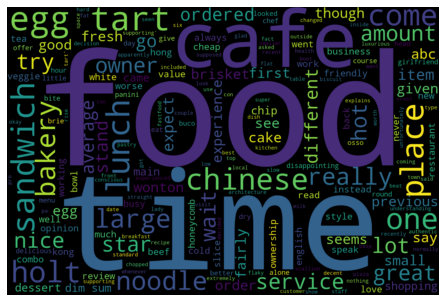

In [54]:
#Creating a word cloud for the reviews of Cafe category
wordcloud(clean_cafe)

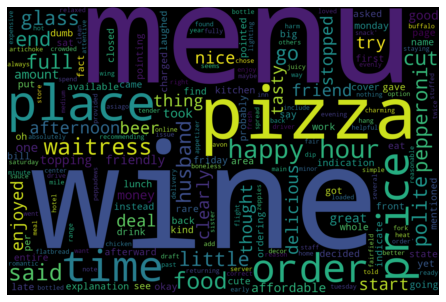

In [55]:
#Creating a word cloud for the reviews of Restaurant category
wordcloud(clean_restaurant)

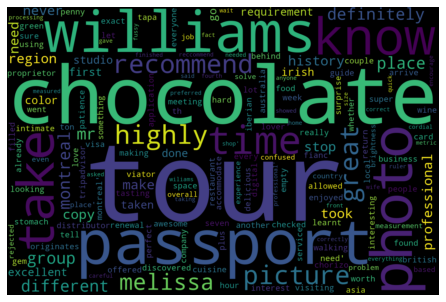

In [56]:
#Creating a word cloud for the reviews of Hotel category
wordcloud(clean_hotel)

* Word Cloud is a data visualization technique used for representing text data in which size of each word depicts its frequency
* From the plots, it is observed that there are many common words across the three categories and most of the words revolve around the domain 'Food'
* Possessing common words will enhance the usability of the trained model across various categories
* Hence, we can expect a higher accuracy score when the model is trained with one category and tested with other categories

## TASK-3: Predictions of Classification model and Evaluation of Multiple Categories

Here classification of multiple categories of data is done. The function com_classification takes five parameters as input:
* Data Frame to be fitted
* Data Frame to be transformed
* Data Frame to be transformed
* Type of Vectorizer to be used: 
        1 or 2 -> 1-CountVectorizer (count the number of times a word appears in reviews)
                  2-TfidfVectorizer (overall document weightage of reviews)
* Type of Classifier to be used:
        1,2,3 -> 1-Multinomial Naive Bayes Classifier
                 2-Logistic Regression Classifier
                 3-Random Forest Classifier

In [31]:
# Single function that trains and tests with different categories of data
# Assigning default values to the function: Vectorizer-Count Vectorizer & Classifier- Logistic
def com_classifier(df_fit0, df_trans1,df_trans2,vectorizer=1, classifier=2):
   
    if(vectorizer==1):
        #CountVectorizer
        cv = CountVectorizer()
    if(vectorizer==2):
        #TfidfVectorizer
        cv = TfidfVectorizer()
   
    df_cv = cv.fit(df_fit0['Review'])
    trans_a = df_cv.transform(df_fit0['Review'])
    trans_b = df_cv.transform(df_trans1['Review'])
    trans_c = df_cv.transform(df_trans2['Review'])
    
    df0_matrix = pd.DataFrame(trans_a.toarray(), columns=cv.get_feature_names())
    df0_matrix.index = df_fit0.index

    df1_matrix = pd.DataFrame(trans_b.toarray(), columns=cv.get_feature_names())
    df1_matrix.index = df_trans1.index
    
    df2_matrix = pd.DataFrame(trans_c.toarray(), columns=cv.get_feature_names())
    df2_matrix.index = df_trans2.index
    
    #CLASSIFIER
    if(classifier==1):
        # NAIVE BAYES 
        print("\nNaive Bayes Classifier")
        LR= MultinomialNB()
    
    if(classifier==2):
        print("\nLogistic Regression Classifier")
        # LOGISTIC REGRESSION
        # Create the model with 'lbfgs' solver which denotes limited memory optimization algorithm
        LR= LogisticRegression(solver='lbfgs')
    
    if(classifier==3):
        # RANDOM FOREST
        print("\nRandom Forest Classifier")
        # Create the model with 10 trees
        LR= RandomForestClassifier(n_estimators=10)
    
    X_train=df0_matrix
    y_train=df_fit0['Class']
    LR.fit(X_train,y_train)
    
    #Evaluation using HOLD-OUT STRATGEY
    #Classification_report is used to quantify the quality of prediction by computing various metric scores
    #From the result, the overall accuracy score as well as precision, recall, f1-score and support is computed for each class label
    y1_predict=LR.predict(df1_matrix)
    LR1_accuracy=accuracy_score(df_trans1['Class'],y1_predict)
    print("\n Accuracy Score(#1)", LR1_accuracy*100)
    LR1_accuracy1=classification_report(df_trans1['Class'],y1_predict)
    print("\n Evaluation Summary(#1)")
    print(LR1_accuracy1)
    
    y2_predict=LR.predict(df2_matrix)
    LR2_accuracy=accuracy_score(df_trans2['Class'],y2_predict)
    print("\n Accuracy Score(#2)", LR2_accuracy*100)
    LR2_accuracy1=classification_report(df_trans2['Class'],y2_predict)
    print("\n Evaluation Summary(#2)")
    print(LR2_accuracy1)
    


    

In [32]:
#Training the system with Cafe category data and testing over Hotel and Restaurant category 
#Using Count Vectorizer and Logistic Regression
print("Training the system with Cafe category data and Testing & Predicting for #1-Hotel and #2-Restaurant category")
com_classifier(clean_cafe,clean_hotel,clean_restaurant,1,2)

Training the system with Cafe category data and Testing & Predicting for #1-Hotel and #2-Restaurant category

Logistic Regression Classifier

 Accuracy Score(#1) 83.6

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80       824
     Postive       0.87      0.85      0.86      1176

    accuracy                           0.84      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.84      0.84      0.84      2000


 Accuracy Score(#2) 85.39999999999999

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.87      0.76      0.81       838
     Postive       0.84      0.92      0.88      1162

    accuracy                           0.85      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [33]:
#Training the system with Hotel category data and testing over Restaurant and Cafe category 
#Using Tfidf Vectorizer and Multinomial Naive Bayes Classifier
print("Training the system with Hotel category data and Testing & Predicting for #1-Restaurant and #2-Cafe category")
com_classifier(clean_hotel,clean_restaurant,clean_cafe,2,1)

Training the system with Hotel category data and Testing & Predicting for #1-Restaurant and #2-Cafe category

Naive Bayes Classifier

 Accuracy Score(#1) 72.0

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.98      0.34      0.50       838
     Postive       0.68      0.99      0.81      1162

    accuracy                           0.72      2000
   macro avg       0.83      0.67      0.65      2000
weighted avg       0.80      0.72      0.68      2000


 Accuracy Score(#2) 80.10000000000001

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.96      0.27      0.42       538
     Postive       0.79      1.00      0.88      1462

    accuracy                           0.80      2000
   macro avg       0.87      0.63      0.65      2000
weighted avg       0.83      0.80      0.76      2000



In [34]:
#Training the system with Restaurant category data and testing over Cafe and Hotel category 
#Using Count Vectorizer and Random Forest Classifiier
print("Training the system with Restaurant category data and Testing & Predicting for #1-Cafe and #2-Hotel category")
com_classifier(clean_restaurant,clean_cafe,clean_hotel,1,3)

Training the system with Restaurant category data and Testing & Predicting for #1-Cafe and #2-Hotel category

Random Forest Classifier

 Accuracy Score(#1) 80.0

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.61      0.72      0.66       538
     Postive       0.89      0.83      0.86      1462

    accuracy                           0.80      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.81      0.80      0.80      2000


 Accuracy Score(#2) 75.6

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.67      0.81      0.73       824
     Postive       0.84      0.72      0.78      1176

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.75      2000
weighted avg       0.77      0.76      0.76      2000



#### Owing to the fact accuracy score is higher when the numeric representation of the data is done using Count vectorizer and fed in Logistic regression Classifier, the following predictions are done:


In [35]:
#Training the system with Cafe category data and testing over Hotel and Restaurant category 
#Using Count Vectorizer and Logistic Regression
print("Training the system with Cafe category data and Testing & Predicting for #1-Hotel and #2-Restaurant category")
com_classifier(clean_cafe,clean_hotel,clean_restaurant,1,2)

Training the system with Cafe category data and Testing & Predicting for #1-Hotel and #2-Restaurant category

Logistic Regression Classifier

 Accuracy Score(#1) 83.6

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.79      0.82      0.80       824
     Postive       0.87      0.85      0.86      1176

    accuracy                           0.84      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.84      0.84      0.84      2000


 Accuracy Score(#2) 85.39999999999999

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.87      0.76      0.81       838
     Postive       0.84      0.92      0.88      1162

    accuracy                           0.85      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [35]:
#Training the system with Hotel category data and testing over Restaurant and Cafe category 
#Using Count Vectorizer and Logistic Regression
print("Training the system with Hotel category data and Testing & Predicting for #1-Restaurant and #2-Cafe category")
com_classifier(clean_hotel,clean_restaurant,clean_cafe,1,2)

Training the system with Hotel category data and Testing & Predicting for #1-Restaurant and #2-Cafe category

 Accuracy Score(#1) 82.3

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.82      0.74      0.78       838
     Postive       0.82      0.88      0.85      1162

    accuracy                           0.82      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.82      0.82      0.82      2000


 Accuracy Score(#2) 82.89999999999999

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.68      0.70      0.69       538
     Postive       0.89      0.88      0.88      1462

    accuracy                           0.83      2000
   macro avg       0.78      0.79      0.79      2000
weighted avg       0.83      0.83      0.83      2000



In [36]:
#Training the system with Restaurant category data and testing over Cafe and Hotel category 
#Using Count Vectorizer and Logistic Regression
print("Training the system with Restaurant category data and Testing & Predicting for #1-Cafe and #2-Hotel category")
com_classifier(clean_restaurant,clean_cafe,clean_hotel,1,2)

Training the system with Restaurant category data and Testing & Predicting for #1-Cafe and #2-Hotel category

Logistic Regression Classifier

 Accuracy Score(#1) 86.3

 Evaluation Summary(#1)
              precision    recall  f1-score   support

    Negative       0.72      0.80      0.76       538
     Postive       0.92      0.89      0.90      1462

    accuracy                           0.86      2000
   macro avg       0.82      0.84      0.83      2000
weighted avg       0.87      0.86      0.87      2000


 Accuracy Score(#2) 83.39999999999999

 Evaluation Summary(#2)
              precision    recall  f1-score   support

    Negative       0.75      0.89      0.82       824
     Postive       0.91      0.79      0.85      1176

    accuracy                           0.83      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.85      0.83      0.84      2000



### Results:
* Each classification model has its own benefits. So when a model has to be trained, choose the model that best fits the data during the Exploratory Data Analysis stage
* The type of vectorizer 'Count Vectorizer' and 'Tfidf Vectorizer' are only used to vectorize the data and does not improve the accuracy of the model in any way
* If the system has to be trained with one category and tested with other, the data of both the sets has to be as clean as possible for better accuracy
* Since the data given are the customer reveiews, we will encounter a lot of challenges with words from different languages or usage of short forms, abbreviations,non-sensical text etc
* This arises a need to do a detailed preprocessing though making sure no significant words are missed

* Here, the model was trained with various classification models and it was found that 'Logistic Regression' gave better  accuracy over other models
* For a single dataset, Cross validation strategy was used for evaluation; For multiple categories, Hold-Out Stratgey was used